In [6]:
# Imports
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from langdetect import detect
from tqdm import tqdm
import nltk
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
import xgboost as xgb

In [9]:
# Load dataset
df = pd.read_csv("/content/dataset-tickets-multi-lang-4-20k.csv")

# Detect language and remove German rows
tqdm.pandas()  # Enable progress bar
df['lang'] = df['body'].progress_apply(lambda x: detect(str(x)))
df = df[df['lang'] != 'de']  # Keep only non-German entries

# Keep required columns and drop missing
df = df[['body', 'type']].dropna()

100%|██████████| 20000/20000 [00:54<00:00, 368.11it/s]


In [7]:
# Download NLTK resources
nltk.download(['punkt', 'stopwords', 'wordnet', 'punkt_tab'])

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Preload stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [8]:
# Function to clean text
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

In [10]:
# 4. Apply cleaning function
df['cleaned_body'] = df['body'].apply(clean_text)

# 5. Encode labels
label_encoder = LabelEncoder()
df['type_encoded'] = label_encoder.fit_transform(df['type'])

# Display the first few rows with the new columns
display(df.head())

,body,type,cleaned_body,type_encoded
1,Seeking information on digital strategies that...,Request,seeking information digital strategy aid brand...,3
2,I am contacting you to request information on ...,Request,contacting request information data analytics ...,3
4,"Dear Customer Support, I am reaching out to in...",Request,dear customer support reaching inquire securit...,3
5,Inquiring about best practices for securing me...,Request,inquiring best practice securing medical data ...,3
7,"The integration stopped working unexpectedly, ...",Problem,integration stopped working unexpectedly causi...,2


In [11]:

tfidf_vectorizer = TfidfVectorizer(max_features=5000) # You can adjust max_features
X = tfidf_vectorizer.fit_transform(df['cleaned_body']).toarray()
y = df['type_encoded']

# Apply SMOTE for handling imbalanced data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [12]:

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 8. Train SVM Classifier
from sklearn.svm import SVC
svm_model = SVC(kernel='linear', random_state=42) # You can change the kernel
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

In [13]:
# 10. Evaluate the model - Accuracy and Classification Report
from sklearn.metrics import accuracy_score, classification_report

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.851543140346925
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1128
           1       0.74      0.67      0.70      1098
           2       0.71      0.77      0.74      1137
           3       0.99      0.98      0.98      1076

    accuracy                           0.85      4439
   macro avg       0.85      0.85      0.85      4439
weighted avg       0.85      0.85      0.85      4439



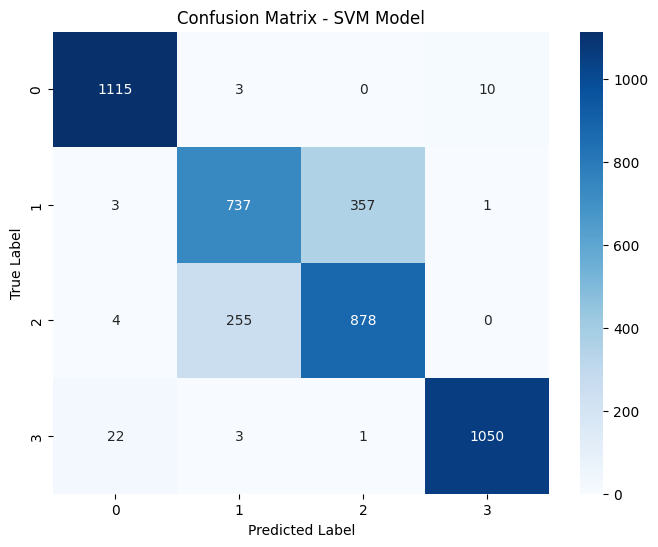

In [16]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_svm = confusion_matrix(y_test, svm_model.predict(X_test))

plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - SVM Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [14]:
import xgboost as xgb


xgb_model = xgb.XGBClassifier(random_state=42) # You can change hyperparameters
xgb_model.fit(X_train, y_train)


y_pred = xgb_model.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8812795674701509


In [17]:
from sklearn.metrics import classification_report

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      1128
           1       0.76      0.83      0.79      1098
           2       0.82      0.75      0.79      1137
           3       0.97      0.98      0.98      1076

    accuracy                           0.88      4439
   macro avg       0.88      0.88      0.88      4439
weighted avg       0.88      0.88      0.88      4439



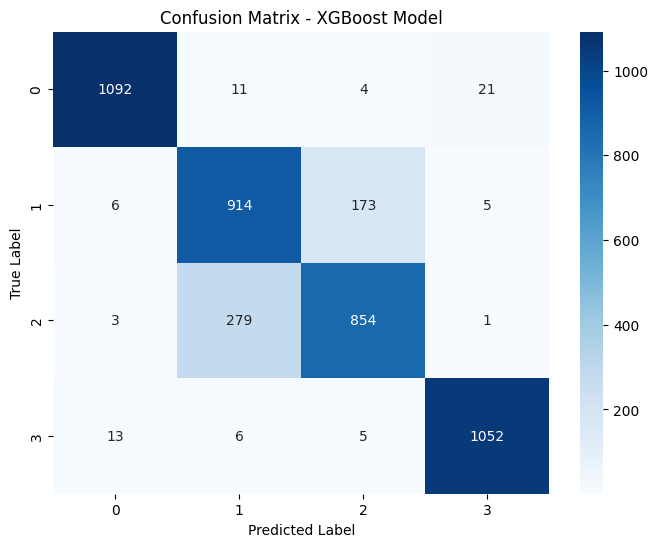

In [18]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_xgb = confusion_matrix(y_test, xgb_model.predict(X_test))

plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - XGBoost Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()